# Classification of UVA Buildings with CNNs

This notebook contains implementations of several convolutional neural network (CNN) architectures with the goal of classifying buildings at the University of Virginia.

# Load Packages

In [3]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

2.8.0


In [4]:
# Configure TensorFlow to GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1



# Import Dataset

In [5]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = '../data'
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 14286 files belonging to 2 classes.
Using 11429 files for training.
Found 14286 files belonging to 2 classes.
Using 2857 files for validation.


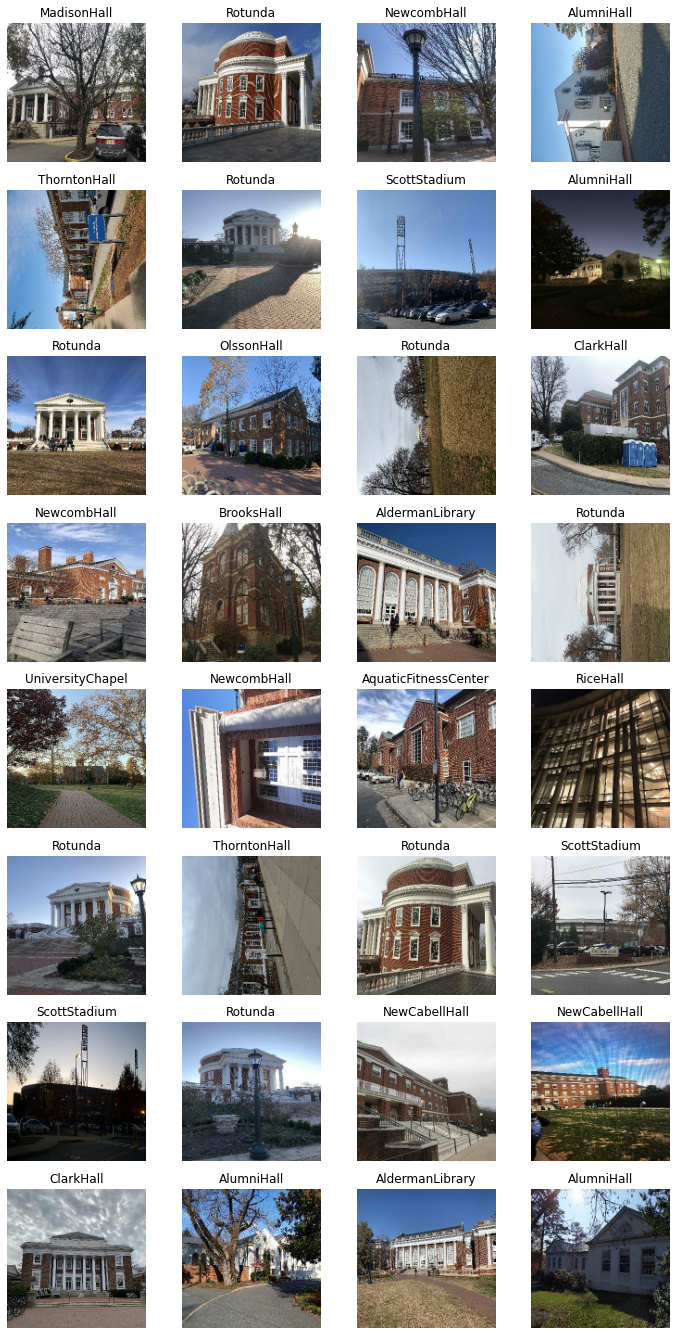

In [34]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# Model 1

In [28]:
num_classes = len(class_names) 

model = keras.models.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)       

In [31]:
epochs = 50
model.fit(train_ds,
          validation_data=validation_ds,
          epochs=epochs) 

Epoch 1/50
358/358 [==============================] - 14s 36ms/step - loss: 2.2191 - accuracy: 0.3238 - val_loss: 1.8239 - val_accuracy: 0.4638
Epoch 2/50
358/358 [==============================] - 13s 35ms/step - loss: 1.3567 - accuracy: 0.6050 - val_loss: 1.3318 - val_accuracy: 0.6213
Epoch 3/50
358/358 [==============================] - 13s 35ms/step - loss: 0.7911 - accuracy: 0.7673 - val_loss: 1.3882 - val_accuracy: 0.6307
Epoch 4/50
358/358 [==============================] - 13s 35ms/step - loss: 0.3852 - accuracy: 0.8873 - val_loss: 1.5692 - val_accuracy: 0.6447
Epoch 5/50
358/358 [==============================] - 13s 35ms/step - loss: 0.1622 - accuracy: 0.9528 - val_loss: 1.7687 - val_accuracy: 0.6416
Epoch 6/50
358/358 [==============================] - 13s 35ms/step - loss: 0.0949 - accuracy: 0.9723 - val_loss: 1.9294 - val_accuracy: 0.6521
Epoch 7/50
358/358 [==============================] - 13s 36ms/step - loss: 0.0767 - accuracy: 0.9766 - val_loss: 2.1144 - val_accuracy:

# Model 2: Transfer Learning Resnet50

In [63]:
data_augmentation = tf.keras.Sequential([
  keras.layers.Resizing(224, 224),
#   keras.layers.Rescaling(1./255),
#   keras.layers.RandomFlip("horizontal_and_vertical"),
#   keras.layers.RandomRotation(0.5),
])

train_ds_2 = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_ds_2 = validation_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

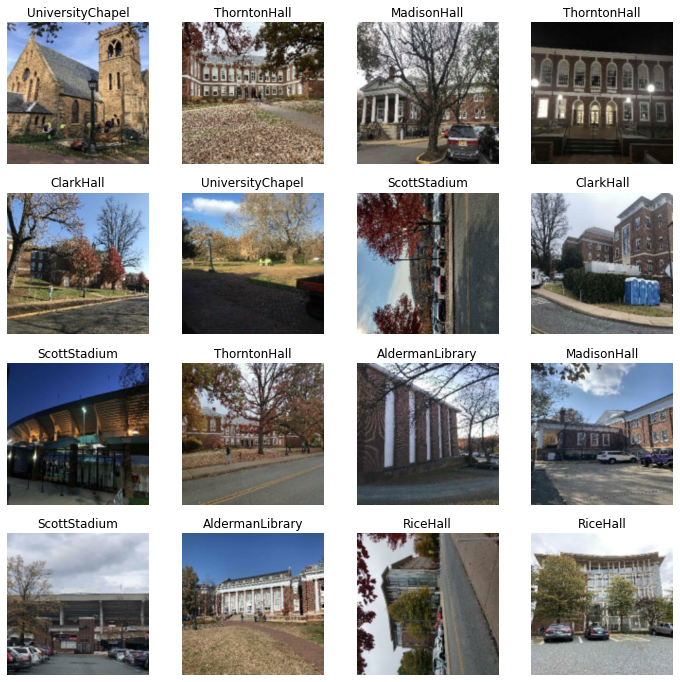

In [64]:
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds_2.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [65]:
model = keras.applications.resnet50.ResNet50()

In [16]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [66]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [67]:
epochs = 12
model.fit(train_ds_2,
          validation_data=validation_ds_2,
          epochs=epochs) 

Epoch 1/12
358/358 [==============================] - 194s 522ms/step - loss: 1.0530 - accuracy: 0.7183 - val_loss: 1.2408 - val_accuracy: 0.6458
Epoch 2/12
358/358 [==============================] - 186s 520ms/step - loss: 0.4075 - accuracy: 0.8877 - val_loss: 1.4798 - val_accuracy: 0.6290
Epoch 3/12
358/358 [==============================] - 187s 521ms/step - loss: 0.2835 - accuracy: 0.9192 - val_loss: 0.9403 - val_accuracy: 0.7571
Epoch 4/12
358/358 [==============================] - 188s 524ms/step - loss: 0.1815 - accuracy: 0.9474 - val_loss: 2.6793 - val_accuracy: 0.4662
Epoch 5/12
358/358 [==============================] - 190s 531ms/step - loss: 0.1696 - accuracy: 0.9520 - val_loss: 1.1829 - val_accuracy: 0.7028
Epoch 6/12
358/358 [==============================] - 187s 523ms/step - loss: 0.1319 - accuracy: 0.9594 - val_loss: 0.6216 - val_accuracy: 0.8386
Epoch 7/12
358/358 [==============================] - 188s 524ms/step - loss: 0.0866 - accuracy: 0.9736 - val_loss: 0.7332 -

# Model 3: Transfer Learning Xception

In [58]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
])

train_ds_3 = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_ds_3 = validation_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

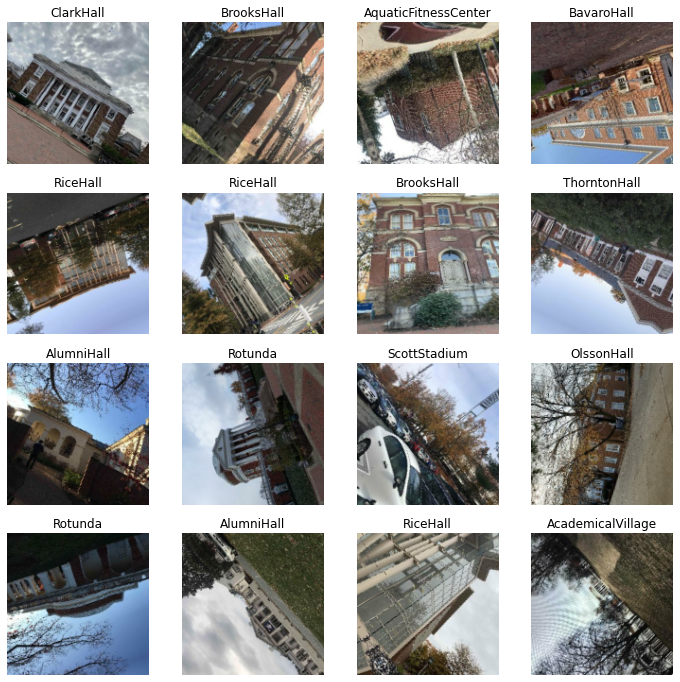

In [59]:
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds_3.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [60]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(class_names), activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [61]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_7
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_8
13 block2_pool
14 batch_normalization_8
15 add_24
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_9
23 block3_pool
24 batch_normalization_9
25 add_25
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_10
33 block4_pool
34 batch_normalization_10
35 add_26
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_27
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_

In [62]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


epochs = 20
history = model.fit(train_ds_3,
                    validation_data=validation_ds_3,
                    epochs=epochs)

Epoch 1/20
358/358 [==============================] - 210s 574ms/step - loss: 1.1003 - accuracy: 0.6842 - val_loss: 0.5398 - val_accuracy: 0.8519
Epoch 2/20
358/358 [==============================] - 203s 568ms/step - loss: 0.3917 - accuracy: 0.8941 - val_loss: 0.3551 - val_accuracy: 0.9069
Epoch 3/20
358/358 [==============================] - 205s 571ms/step - loss: 0.2713 - accuracy: 0.9269 - val_loss: 0.2616 - val_accuracy: 0.9342
Epoch 4/20
358/358 [==============================] - 205s 571ms/step - loss: 0.1934 - accuracy: 0.9479 - val_loss: 0.2609 - val_accuracy: 0.9419
Epoch 5/20
358/358 [==============================] - 204s 569ms/step - loss: 0.1541 - accuracy: 0.9609 - val_loss: 0.2460 - val_accuracy: 0.9419
Epoch 6/20
358/358 [==============================] - 204s 569ms/step - loss: 0.1349 - accuracy: 0.9642 - val_loss: 0.2574 - val_accuracy: 0.9422
Epoch 7/20
358/358 [==============================] - 204s 570ms/step - loss: 0.1145 - accuracy: 0.9707 - val_loss: 0.2238 -

Sucessfully predicted wtih 95.4% accuracy!